In [1]:
import rebound as rb
import reboundx
from reboundx import constants as rbx_constants
import numpy as np
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from test_particle_secular_hamiltonian import SyntheticSecularTheory
import celmech as cm
import assist
import sys
sys.path.insert(0, "..")
import utils

from matplotlib import pyplot as plt

Searching NASA Horizons for 'sun'... 
https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=%27sun%27&START_TIME=%27JD2460200.500000%27&STOP_TIME=%27JD2460200.60000000%27&MAKE_EPHEM=%27YES%27&EPHEM_TYPE=%27VECTORS%27&CENTER=%27%400%27&REF_PLANE=%27ecliptic%27&STEP_SIZE=%272%27&REF_SYSTEM=%27J2000%27&VEC_CORR=%27NONE%27&OUT_UNITS=%27KM-S%27&CSV_FORMAT=%27NO%27&VEC_DELTA_T=%27NO%27&VEC_TABLE=%273%27&VEC_LABELS=%27NO%27
Found: Sun (10) 


In [2]:
# used for getting fmft result closest to target frequency
def closest_key_entry(d, target):
    """
    Given a dictionary `d` with float keys and a target float `target`,
    returns a tuple (key, value) where the key is the one in `d`
    closest to `target`.

    Parameters
    ----------
    d : dict
        Dictionary with float keys.
    target : float
        The float to compare keys against.

    Returns
    -------
    tuple
        The (key, value) pair whose key is closest to `target`.
    """
    closest_key = min(d.keys(), key=lambda k: abs(k - target))
    return closest_key, d[closest_key]


# Outer solar system synthetic secular theory
This notebook uses a numerical integration and the frequency modified Fourier transform to generate a synthetic secular theory for the outer solar system planets.

In [3]:
start_time = 2460200.5
planets = ("Jupiter","Saturn","Uranus","Neptune")

Searching NASA Horizons for 'Sun'... 
https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=%27Sun%27&START_TIME=%27JD2460200.500000%27&STOP_TIME=%27JD2460200.60000000%27&MAKE_EPHEM=%27YES%27&EPHEM_TYPE=%27VECTORS%27&CENTER=%27%400%27&REF_PLANE=%27ecliptic%27&STEP_SIZE=%272%27&REF_SYSTEM=%27J2000%27&VEC_CORR=%27NONE%27&OUT_UNITS=%27KM-S%27&CSV_FORMAT=%27NO%27&VEC_DELTA_T=%27NO%27&VEC_TABLE=%273%27&VEC_LABELS=%27NO%27
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=%27Jupiter%27&START_TIME=%27JD2460200.500000%27&STOP_TIME=%27JD2460200.60000000%27&MAKE_EPHEM=%27YES%27&EPHEM_TYPE=%27VECTORS%27&CENTER=%27%400%27&REF_PLANE=%27ecliptic%27&STEP_SIZE=%272%27&REF_SYSTEM=%27J2000%27&VEC_CORR=%27NONE%27&OUT_UNITS=%27KM-S%27&CSV_FORMAT=%27NO%27&VEC_DELTA_T=%27NO%27&VEC_TABLE=%273%27&VEC_LABELS=%27NO%27
https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND=%275%27&START_TIME=%27JD2460200.500000%27&STOP_TIME=%27

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.synchronize().", RuntimeWarning)


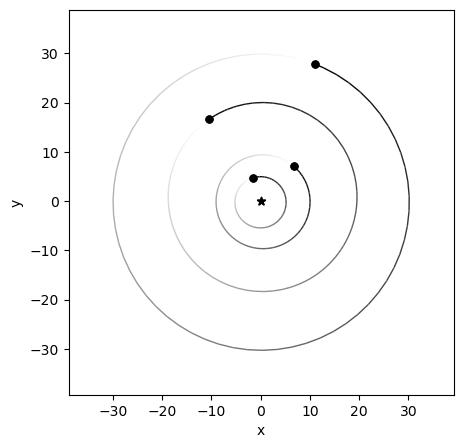

In [4]:
sim = rb.Simulation()

rebx = reboundx.Extras(sim)
gr = rebx.load_force("gr")
rebx.add_force(gr)
gr.params['c'] = rbx_constants.C

sim.add("Sun", date="JD%f"%start_time)
sim.add("Jupiter", date="JD%f"%start_time)
sim.add("Saturn", date="JD%f"%start_time)
sim.add("Uranus", date="JD%f"%start_time)
sim.add("Neptune", date="JD%f"%start_time)
sim.move_to_com()

cm.nbody_simulation_utilities.align_simulation(sim)
rb.OrbitPlot(sim)

try: 
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("outer_solar_system.sa",coordinates='heliocentric')
except:
    sim.integrator = 'whfast'
    sim.dt = sim.particles[1].P / 25.
    sim.ri_whfast.safe_mode = 0
    Tfin_approx = 1e7 * 2*np.pi
    total_steps = np.ceil(Tfin_approx / sim.dt)
    Tfin = total_steps * sim.dt + sim.dt
    Nout = 8192
    sim.save_to_file("outer_solar_system.sa",step=int(np.floor(total_steps/Nout)),delete_file=True)
    sim.integrate(Tfin,exact_finish_time=0)
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("outer_solar_system.sa",coordinates='heliocentric')

In [5]:
results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] )* np.exp(1j * results['Omega'])

In [6]:
planets = ("Jupiter","Saturn","Uranus","Neptune")
ecc_fmft_results = dict()
inc_fmft_results = dict()
for i,pl in enumerate(planets):
    ecc_fmft_results[pl] = fmft(results['time'],results['X'][i],14)
    planet_e_freqs = np.array(list(ecc_fmft_results[pl].keys()))
    planet_e_freqs_arcsec_per_yr = planet_e_freqs * 60*60*180/np.pi * (2*np.pi)

    inc_fmft_results[pl] = fmft(results['time'],results['Y'][i],8)
    planet_inc_freqs = np.array(list(inc_fmft_results[pl].keys()))
    planet_inc_freqs_arcsec_per_yr = planet_inc_freqs * 60*60*180/np.pi * (2*np.pi)

    print("")
    print(pl)
    print("g")
    print("-------")
    for g in planet_e_freqs[:6]:
        print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_results[pl][g])))
    print("s")
    print("-------")
    for g in planet_inc_freqs[:4]:
        print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(inc_fmft_results[pl][g])))


Jupiter
g
-------
+04.246 	 0.044206
+28.241 	 0.015694
+03.089 	 0.001843
-30.978 	 0.000642
+52.237 	 0.000571
+464.193 	 0.000396
s
-------
-26.338 	 0.003150
-00.692 	 0.000574
-02.994 	 0.000485
-26.989 	 0.000023

Saturn
g
-------
+28.241 	 0.048225
+04.246 	 0.032965
+52.237 	 0.001925
+03.089 	 0.001533
+345.753 	 0.001510
+464.193 	 0.001246
s
-------
-26.338 	 0.007853
-00.692 	 0.000553
-02.994 	 0.000394
-26.989 	 0.000060

Uranus
g
-------
+04.246 	 0.038084
+03.089 	 0.029027
+305.323 	 0.002078
+00.672 	 0.001663
+28.241 	 0.001549
-501.336 	 0.001350
s
-------
-02.994 	 0.008897
-00.692 	 0.000555
-26.338 	 0.000354
-02.342 	 0.000298

Neptune
g
-------
+00.673 	 0.009122
+03.089 	 0.003707
+04.246 	 0.001941
+432.846 	 0.001352
+305.323 	 0.000568
-93.672 	 0.000164
s
-------
-00.692 	 0.005782
-02.994 	 0.001068
-02.342 	 0.000056
-00.561 	 0.000043


(0.0, 10000000.0)

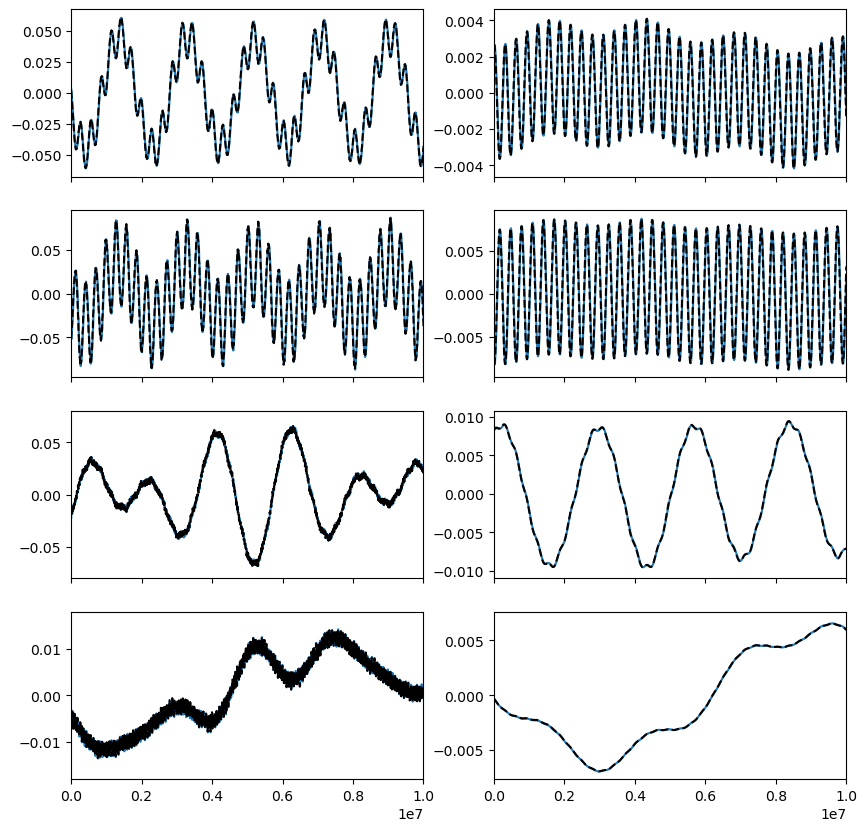

In [7]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
    freq_amp_dict = ecc_fmft_results[pl]
    ax[i,0].plot(results['time'],np.real(results['X'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[i,0].plot(results['time'],np.real(zsoln),'k--')

    freq_amp_dict = inc_fmft_results[pl]
    Ysolns.append(freq_amp_dict)
    ax[i,1].plot(results['time'],np.real(results['Y'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[i,1].plot(results['time'],np.real(zsoln),'k--')
plt.xlim(0,1e7)

In [8]:
ARCSEC_PER_YR = 1/(180*60*60*2)
g_vec = np.zeros(4)
s_vec = np.zeros(3)

g_vec[:3] = np.array(list(ecc_fmft_results['Jupiter'].keys()))[:3]
g_vec[3] = list(ecc_fmft_results['Neptune'].keys())[0]
s_vec[0] = list(inc_fmft_results['Jupiter'].keys())[0]
s_vec[1] = list(inc_fmft_results['Jupiter'].keys())[2]
s_vec[2] = list(inc_fmft_results['Jupiter'].keys())[1]
omega_vec = np.concatenate((g_vec,s_vec))
g_and_s_arc_sec_per_yr = omega_vec / ARCSEC_PER_YR
g_and_s_arc_sec_per_yr

array([  4.24552786,  28.24136038,   3.089066  ,   0.67272162,
       -26.33761107,  -2.99375035,  -0.69243627])

In [9]:
eye_N = np.eye(omega_vec.size,dtype = int)
x_dicts = []
for pl in planets:
    print(pl)    
    print("-"*len(pl))
    print("kvec \t\t\t omega \t err. \t amplitude")
    x_dict = {}
    for i,omega_i in enumerate(omega_vec[:4]):
        omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega_vec[i])
        omega_error = np.abs(omega_N/omega_i-1)
        if omega_error<0.001:
            print (eye_N[i],"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
            x_dict[tuple(eye_N[i])] = amp
    #NL terms
    for a in range(7):
        for b in range(a,7):
            for c in range(7):
                if c==a:
                    continue
                if c==b:
                    continue
                k = np.zeros(7,dtype = int)
                k[a] +=1
                k[b] +=1
                k[c] -=1
                omega=k@omega_vec
                omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega)
                omega_error = np.abs(omega_N/omega-1)
                if omega_error<0.001:
                    print (k,"\t{:+07.3f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
                    x_dict[tuple(k)] = amp
    x_dicts.append(x_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.246	0 	0.04
[0 1 0 0 0 0 0] 	+28.241	0 	0.02
[0 0 1 0 0 0 0] 	+03.089	0 	0.002
[ 1  1 -1  0  0  0  0] 	+29.398	2e-07,	0.0002
[ 1  0  0  0 -1  1  0] 	+27.589	0.0001,	0.0001
[-1  2  0  0  0  0  0] 	+52.237	2e-06,	0.0006
[-1  1  1  0  0  0  0] 	+27.085	3e-06,	0.0002
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.246	4e-07 	0.03
[0 1 0 0 0 0 0] 	+28.241	2e-08 	0.05
[0 0 1 0 0 0 0] 	+03.089	5e-08 	0.002
[ 1  1 -1  0  0  0  0] 	+29.398	1e-07,	0.0006
[ 1  0  0  0 -1  1  0] 	+27.589	0.0001,	0.0003
[-1  2  0  0  0  0  0] 	+52.237	3e-06,	0.002
[-1  1  1  0  0  0  0] 	+27.085	2e-06,	0.0006
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.246	3e-08 	0.04
[0 1 0 0 0 0 0] 	+28.241	1e-07 	0.002
[0 0 1 0 0 0 0] 	+03.089	6e-06 	0.03
[ 2  0 -1  0  0  0  0] 	+05.402	0.0003,	0.0005
Neptune
-------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+04.246	9e-07 	0.002
[0 1 0 0 0 0 0] 	+28.241	4

In [10]:
y_dicts = []
for pl in planets:
    print(pl)    
    print("-"*len(pl))
    print("kvec \t\t\t omega \t err. \t amplitude")
    y_dict = {}
    for i,omega_i in enumerate(omega_vec[4:]):
        omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega_vec[4+i])
        omega_error = np.abs(omega_N/omega_i-1)
        if omega_error<0.001:
            print (eye_N[4+i],"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
            y_dict[tuple(eye_N[4+i])] = amp
    #NL terms
    for a in range(7):
        for b in range(a,7):
            for c in range(7):
                if c==a:
                    continue
                if c==b:
                    continue
                k = np.zeros(7,dtype = int)
                k[a] +=1
                k[b] +=1
                k[c] -=1
                omega=k@omega_vec
                omega_N,amp = closest_key_entry(inc_fmft_results[pl],omega)
                omega_error = np.abs(omega_N/omega-1)
                if omega_error<0.001:
                    print (k,"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
                    y_dict[tuple(k)] = amp
    y_dicts.append(y_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[0 0 0 0 1 0 0] 	-26.338	0 	0.003
[0 0 0 0 0 1 0] 	-02.994	0 	0.0005
[0 0 0 0 0 0 1] 	-00.692	0 	0.0006
[ 1 -1  0  0  0  1  0] 	-26.990	2e-05 	2e-05
[ 1  0 -1  0  0  1  0] 	-01.837	0.0009 	1e-05
[ 0  2  0  0 -1  0  0] 	+82.820	3e-08 	1e-05
[-1  1  0  0  1  0  0] 	-02.342	5e-05 	2e-05
[-1  0  1  0  0  1  0] 	-04.150	0.0004 	1e-05
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[0 0 0 0 1 0 0] 	-26.338	1e-09 	0.008
[0 0 0 0 0 1 0] 	-02.994	5e-08 	0.0004
[0 0 0 0 0 0 1] 	-00.692	7e-06 	0.0006
[ 2  0  0  0 -1  0  0] 	+34.829	2e-07 	2e-05
[ 1  1  0  0 -1  0  0] 	+58.824	9e-08 	2e-05
[ 1 -1  0  0  0  1  0] 	-26.990	2e-05 	6e-05
[ 0  2  0  0 -1  0  0] 	+82.820	2e-08 	4e-05
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[0 0 0 0 1 0 0] 	-26.338	7e-08 	0.0004
[0 0 0 0 0 1 0] 	-02.994	7e-05 	0.009
[0 0 0 0 0 0 1] 	-00.692	0.0005 	0.0006
[ 1  0 -1  0  0  1  0] 	-01.837	0.0004 	0.0002
[-1  1  0  0  1  0  0] 	-02.342	3e-05 	0.0003
[ 0  1 -1  0  1  

In [11]:
solar_system_synthetic_theory = SyntheticSecularTheory(
    [p.m for p in sim.particles[1:]],
    [np.mean(a) for a in results['a']],
    omega_vec,
    x_dicts,
    y_dicts
)

In [12]:
import pickle
with open("solar_system_synthetic_solution.bin","wb") as fi:
    pickle.dump(solar_system_synthetic_theory,fi)
